In [12]:
!cd dataset
!unzip dataset.zip -d dataset

Archive:  dataset.zip
replace dataset/bolsa/20385.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/bolsa/20385.jpg  
  inflating: dataset/bolsa/20386.jpg  
  inflating: dataset/bolsa/20387.jpg  
  inflating: dataset/bolsa/20388.jpg  
  inflating: dataset/bolsa/20389.jpg  
  inflating: dataset/bolsa/20393.jpg  
  inflating: dataset/bolsa/20394.jpg  
  inflating: dataset/bolsa/20397.jpg  
  inflating: dataset/bolsa/20398.jpg  
  inflating: dataset/bolsa/20399.jpg  
  inflating: dataset/bolsa/20410.jpg  
  inflating: dataset/bolsa/20419.jpg  
  inflating: dataset/bolsa/20420.jpg  
  inflating: dataset/bolsa/20421.jpg  
  inflating: dataset/bolsa/20452.jpg  
  inflating: dataset/bolsa/20479.jpg  
  inflating: dataset/bolsa/20487.jpg  
  inflating: dataset/bolsa/20488.jpg  
  inflating: dataset/bolsa/20489.jpg  
  inflating: dataset/bolsa/20490.jpg  
  inflating: dataset/bolsa/20491.jpg  
  inflating: dataset/bolsa/20492.jpg  
  inflating: dataset/bolsa/20493.jpg  
  inflat

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurações
batch_size = 32
img_height = 224
img_width = 224

# Carregar os dados
data_dir = "dataset"

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 192 images belonging to 5 classes.
Found 48 images belonging to 5 classes.


In [52]:
from tensorflow.keras import layers, models

img_height, img_width = 224, 224
num_classes = 5

# Construir o modelo
model = models.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.2560 - loss: 2.2583 - val_accuracy: 0.2500 - val_loss: 1.4143
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.5022 - loss: 1.3141 - val_accuracy: 0.9375 - val_loss: 0.7836
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7823 - loss: 0.6964 - val_accuracy: 0.9375 - val_loss: 0.3241
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9002 - loss: 0.2742 - val_accuracy: 0.9583 - val_loss: 0.0863
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9772 - loss: 0.0648 - val_accuracy: 1.0000 - val_loss: 0.0210


In [57]:
results = model.evaluate(val_ds)
print(f"Validation Loss, Validation Accuracy: {results}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 1.0000 - loss: 0.0189
Validation Loss, Validation Accuracy: [0.020994670689105988, 1.0]


In [87]:
print("Model Input Shape:", model.input_shape)
print("Model Layers:", model.layers)

Model Input Shape: (None, 224, 224, 3)
Model Layers: [<Conv2D name=conv2d_21, built=True>, <MaxPooling2D name=max_pooling2d_21, built=True>, <Conv2D name=conv2d_22, built=True>, <MaxPooling2D name=max_pooling2d_22, built=True>, <Conv2D name=conv2d_23, built=True>, <MaxPooling2D name=max_pooling2d_23, built=True>, <Flatten name=flatten_8, built=True>, <Dense name=dense_15, built=True>, <Dense name=dense_16, built=True>]


In [174]:

if not os.path.exists('/content/ImgSim/'):
    os.mkdir('/content/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/ImgSim/bit_feature_extractor.keras')

saved_model_path = '/content/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

In [175]:
#hide
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [176]:
img_paths = []
for path in Path('/content/dataset/').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [177]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [178]:
#hide-output
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('bit_feature_extractor.keras')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [179]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [180]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 240/240 [01:06<00:00,  3.64it/s]


In [181]:
import os
import numpy as np
from tqdm import tqdm

# Função para redimensionar o vetor para o tamanho desejado
def resize_vector(vector, size=256):
    if len(vector) > size:
        return vector[:size]  # Truncate if vector is too long
    elif len(vector) < size:
        return np.pad(vector, (0, size - len(vector)), 'constant')  # Pad with zeros if vector is too short
    return vector


In [182]:
# Caminho do diretório que contém os arquivos .npz
input_dir = "/content/img_vectors/"
output_dir = "/content/img_vectors_redux/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lista de arquivos .npz no diretório
npz_files = [f for f in os.listdir(input_dir) if f.endswith('.npz')]

for npz_file in tqdm(npz_files):
    # Caminho completo do arquivo de entrada e saída
    input_path = os.path.join(input_dir, npz_file)
    output_path = os.path.join(output_dir, npz_file)

    # Carregar o vetor do arquivo .npz
    vector = np.loadtxt(input_path, delimiter=',')

    # Redimensionar o vetor para o comprimento desejado
    resized_vector = resize_vector(vector, size=256)

    # Salvar o vetor redimensionado no arquivo .npz
    np.savetxt(output_path, resized_vector, delimiter=',')

print("Todos os vetores foram redimensionados com sucesso!")


100%|██████████| 240/240 [00:07<00:00, 33.44it/s]

Todos os vetores foram redimensionados com sucesso!


In [183]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

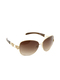

In [184]:
test_img = '/content/dataset/oculos/16848.jpg'
dispImage(test_img)

In [185]:
import pandas as pd

data = {
    'id': [1, 2, 3, 4, 5],
    'masterCategory': ['Bolsa', 'Calcado', 'Oculos', 'Relogio', 'Nenhum'],
}

df = pd.DataFrame(data)
df_selected = df[['id', 'masterCategory']]
df_selected.to_csv('/content/styles.csv', index=False, columns=['id', 'masterCategory'])


In [186]:
#hide-output
styles = pd.read_csv('/content/styles.csv')
styles['id'] = styles['id'].astype('str')
styles.to_csv('/content/styles.csv', index=False)

In [187]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [188]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors_redux/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [189]:
print(allfiles)

['/content/img_vectors_redux/16875.npz', '/content/img_vectors_redux/16896.npz', '/content/img_vectors_redux/16882.npz', '/content/img_vectors_redux/20505.npz', '/content/img_vectors_redux/25615.npz', '/content/img_vectors_redux/25634.npz', '/content/img_vectors_redux/20621.npz', '/content/img_vectors_redux/25616.npz', '/content/img_vectors_redux/25655.npz', '/content/img_vectors_redux/2398.npz', '/content/img_vectors_redux/25629.npz', '/content/img_vectors_redux/16939.npz', '/content/img_vectors_redux/2378.npz', '/content/img_vectors_redux/25656.npz', '/content/img_vectors_redux/2496.npz', '/content/img_vectors_redux/25652.npz', '/content/img_vectors_redux/25607.npz', '/content/img_vectors_redux/16861.npz', '/content/img_vectors_redux/16846.npz', '/content/img_vectors_redux/20385.npz', '/content/img_vectors_redux/20524.npz', '/content/img_vectors_redux/20397.npz', '/content/img_vectors_redux/25654.npz', '/content/img_vectors_redux/16898.npz', '/content/img_vectors_redux/16852.npz', '/

In [190]:
for findex, fname in tqdm(enumerate(allfiles)):
  print(findex)
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

print(file_index_to_product_id)


86it [00:00, 853.43it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


240it [00:00, 871.68it/s]

175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
{}


In [191]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [192]:
file_path = '/content/ImgSim/'

In [193]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

In [194]:
#hide
from PIL import Image
import matplotlib.image as mpimg

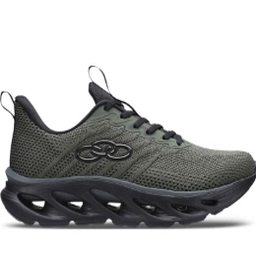

In [214]:
import numpy as np
img_addr = ''

test_img = 'tenis.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 256
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = 256
img = img.resize((basewidth,hsize), Image.LANCZOS)
img

In [215]:
import numpy as np

# Função para redimensionar o vetor para o tamanho desejado
def resize_vector(vector, size=256):
    if len(vector) > size:
        return vector[:size]  # Truncate if vector is too long
    elif len(vector) < size:
        return np.pad(vector, (0, size - len(vector)), 'constant')  # Pad with zeros if vector is too short
    return vector

# Redimensionar o vetor test_vec para 256 elementos
test_vec = resize_vector(test_vec, size=256)


In [225]:
print(file_index_to_file_name)

{0: '16875', 1: '16896', 2: '16882', 3: '20505', 4: '25615', 5: '25634', 6: '20621', 7: '25616', 8: '25655', 9: '2398', 10: '25629', 11: '16939', 12: '2378', 13: '25656', 14: '2496', 15: '25652', 16: '25607', 17: '16861', 18: '16846', 19: '20385', 20: '20524', 21: '20397', 22: '25654', 23: '16898', 24: '16852', 25: '16891', 26: '16938', 27: '16863', 28: '16880', 29: '16887', 30: '16893', 31: '25630', 32: '20389', 33: '2389', 34: '2384', 35: '20568', 36: '2502', 37: '20491', 38: '25646', 39: '25657', 40: '2499', 41: '20493', 42: '25610', 43: '20567', 44: '16895', 45: '25658', 46: '25461', 47: '20610', 48: '25454', 49: '20523', 50: '20615', 51: '20501', 52: '16873', 53: '2376', 54: '16862', 55: '16845', 56: '2500', 57: '25636', 58: '25622', 59: '25457', 60: '25662', 61: '25460', 62: '20421', 63: '20489', 64: '25637', 65: '25611', 66: '25627', 67: '16858', 68: '25667', 69: '16870', 70: '16860', 71: '2504', 72: '16877', 73: '2399', 74: '2509', 75: '25608', 76: '25453', 77: '16884', 78: '16

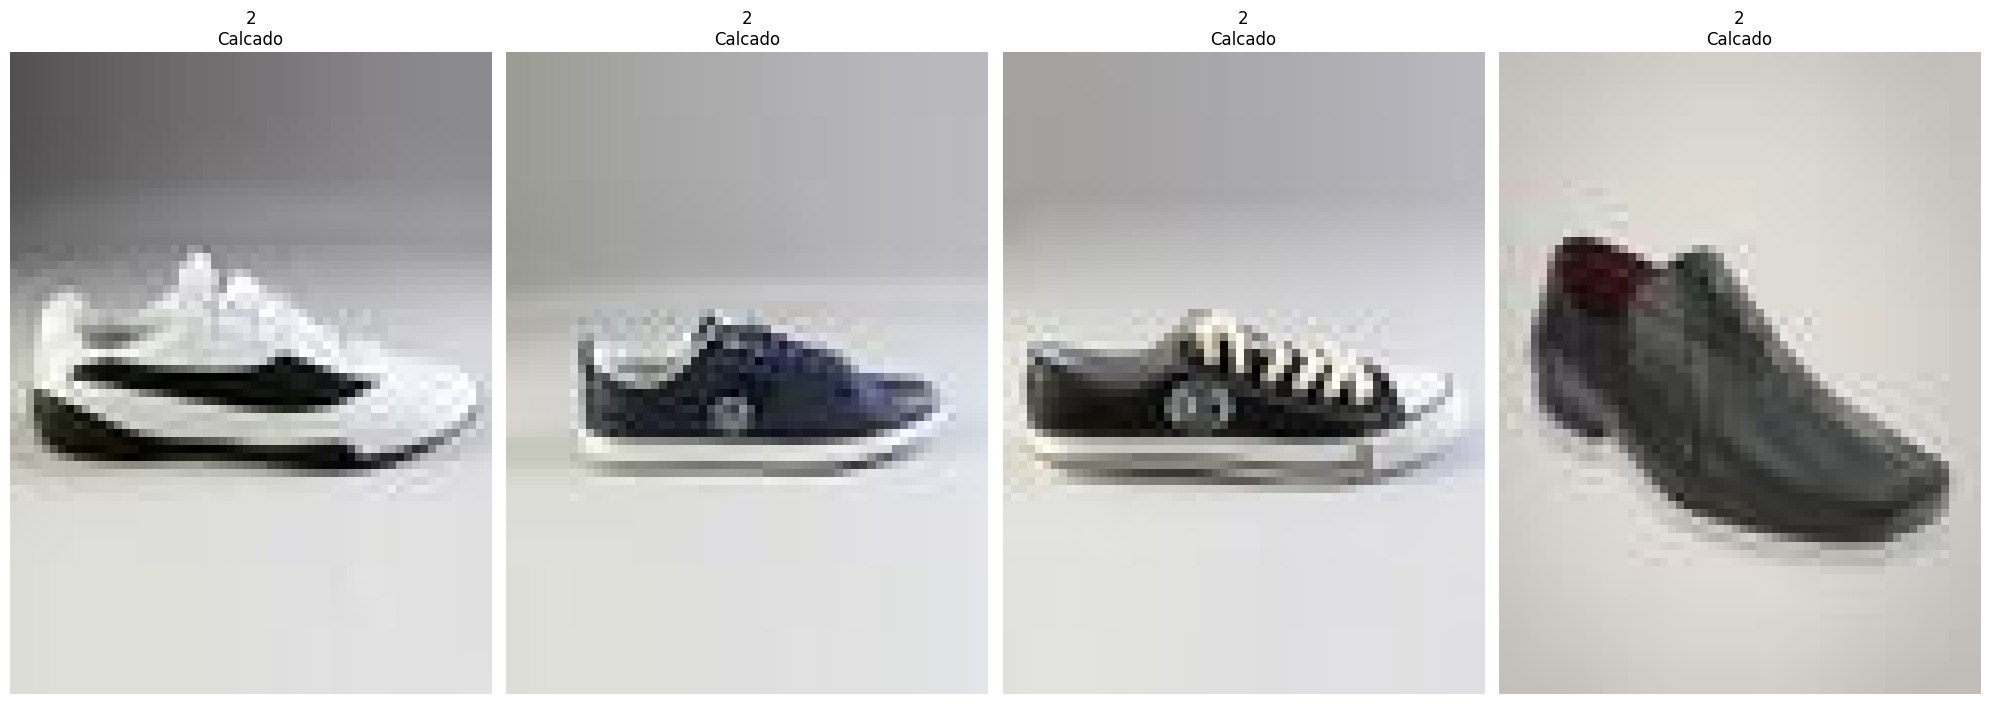

In [227]:
path_dict = {}
for path in Path('/content/dataset').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()